# Pytorch-对MNIST分类可解释性分析

用Pytorch构建简单的卷积神经网络，在MNIST手写数字数据集上，使用shap的Deep Explainer进行可解释性分析。

可视化每一张图像的每一个像素，对模型预测为每一个类别的影响。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 导入工具包

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

## 用Pytorch构建卷积神经网络

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

## 初始化模型

In [3]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

## 载入MNIST数据集

In [4]:
train_dataset = datasets.MNIST('mnist_data', 
                               train=True, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = datasets.MNIST('mnist_data', 
                               train=False, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True)

## 训练模型

In [6]:
num_epochs = 5
device = torch.device('cpu')

def train(model, device, train_loader, optimizer, epoch):
    # 训练一个 epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    # 测试一个 epoch
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300993
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.215593
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.414396

Test set: Average loss: 0.0049, Accuracy: 8030/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.144059
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.700564
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.745232

Test set: Average loss: 0.0024, Accuracy: 8980/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.717565
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.595935
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.495957

Test set: Average loss: 0.0017, Accuracy: 9197/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.619386
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.485492
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.450362

Test set: Average loss: 0.0013, Accuracy: 9334/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.591215
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.441404
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.400539

Test set: Average loss: 0.0011

## 获得背景样本和测试样本

In [7]:
images, labels = next(iter(test_loader))

In [8]:
images.shape

torch.Size([256, 1, 28, 28])

In [9]:
# 背景图像样本
background = images[:250]
background.shape

torch.Size([250, 1, 28, 28])

In [10]:
# 测试图像样本
test_images = images[250:254]
test_images.shape

torch.Size([4, 1, 28, 28])

## 初始化Deep Explainer

In [11]:
e = shap.DeepExplainer(model, background)

## 计算每个类别、每张测试图像、每个像素，对应的 shap 值

In [12]:
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [13]:
len(shap_values)

10

In [14]:
# 类别 1，所有测试图像，每个像素的 shap 值
shap_values[1].shape

(4, 1, 28, 28)

## 整理张量结构

In [15]:
# shap 值
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

# 测试图像
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [16]:
shap_numpy[0].shape

(4, 28, 28, 1)

In [17]:
test_numpy.shape

(4, 28, 28, 1)

## 可视化

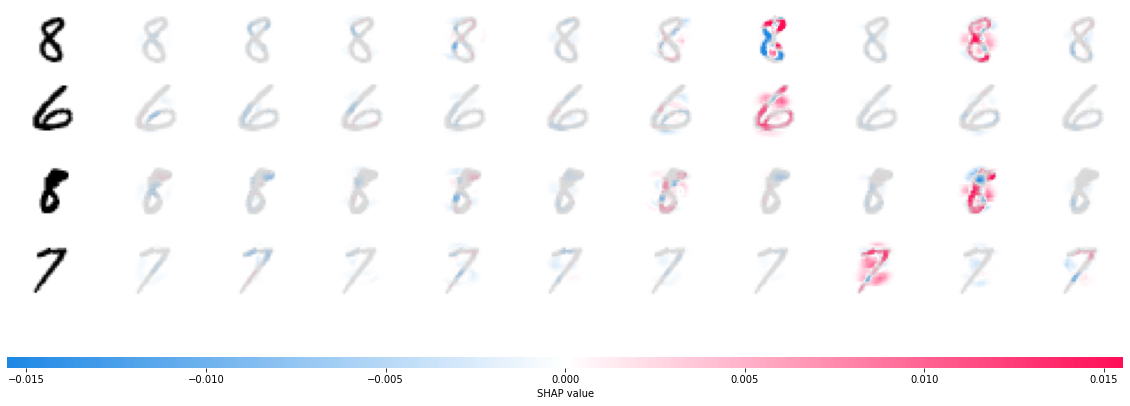

In [18]:
shap.image_plot(shap_numpy, -test_numpy)

展示了每个测试图像样本的每个像素，对10个类别的 shap 值。

红色代表 shap 正值：对模型预测为该类别有正向作用

蓝色代表 shap 负值：对模型预测为该类别有负向作用

AI告诉了我们，它认为7和9的区别，2和3的区别，等等

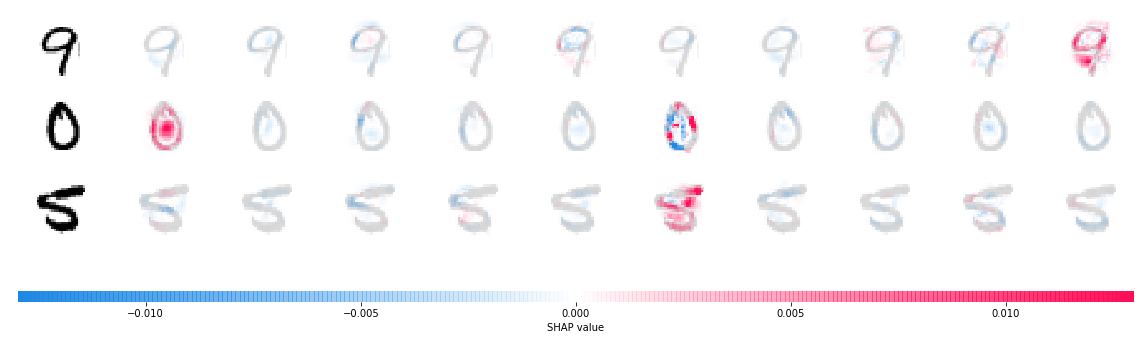

In [8]:
# 无论像素值高低，都可能对某个类别产生较大影响

> 钱和你对我都不重要，没有你，对我很重要。  ————电影“让子弹飞”台词

## 扩展阅读

https://www.bilibili.com/video/BV14J411X7Bb

https://github.com/slundberg/shap/tree/master/notebooks/image_examples/image_classification